## CIFAR-10 Network Comparison Analysis

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import pickle

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# MPS for Apple Silicon, CUDA for NVIDIA, else CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


## Data Loading

In [4]:
file_path="./cifar-10-batches-py/"

def load_cifar10_batch(file_path):
    """Load a single batch of CIFAR-10 data."""
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Load training batches
print("="*60)
print("LOADING CIFAR-10 DATASET FROM LOCAL FILES")
print("="*60)

x_train = []
y_train = []

for i in range(1, 6):
    batch_file = f'cifar-10-batches-py/data_batch_{i}'
    batch = load_cifar10_batch(batch_file)
    x_train.append(batch[b'data'])
    y_train.extend(batch[b'labels'])
    print(f"  Loaded batch {i}")

x_train = np.concatenate(x_train)
y_train = np.array(y_train)

# Load test batch
test_file = 'cifar-10-batches-py/test_batch'
test_batch = load_cifar10_batch(test_file)
x_test = test_batch[b'data']
y_test = np.array(test_batch[b'labels'])

print(f"  Loaded test batch")

# Reshape images from (3072,) to (32, 32, 3)
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nData loaded successfully!")
print(f"\nDataset shapes:")
print(f"  - Training images: {x_train.shape}")
print(f"  - Training labels: {y_train.shape}")
print(f"  - Test images: {x_test.shape}")
print(f"  - Test labels: {y_test.shape}")
print(f"\nData type: {x_train.dtype}")
print(f"Pixel value range: [{x_train.min()}, {x_train.max()}]")

# Quick class distribution check
print(f"\nClass distribution:")
for i in range(10):
    count = np.sum(y_train == i)
    print(f"  {class_names[i]}: {count} images")

LOADING CIFAR-10 DATASET FROM LOCAL FILES
  Loaded batch 1
  Loaded batch 2
  Loaded batch 3
  Loaded batch 4
  Loaded batch 5
  Loaded test batch

Data loaded successfully!

Dataset shapes:
  - Training images: (50000, 32, 32, 3)
  - Training labels: (50000,)
  - Test images: (10000, 32, 32, 3)
  - Test labels: (10000,)

Data type: uint8
Pixel value range: [0, 255]

Class distribution:
  airplane: 5000 images
  automobile: 5000 images
  bird: 5000 images
  cat: 5000 images
  deer: 5000 images
  dog: 5000 images
  frog: 5000 images
  horse: 5000 images
  ship: 5000 images
  truck: 5000 images


/var/folders/hs/4hdxpkyn0g5274r3582nqd_h0000gn/T/ipykernel_2880/2692384811.py:6: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  batch = pickle.load(f, encoding='bytes')


## Data Visualization

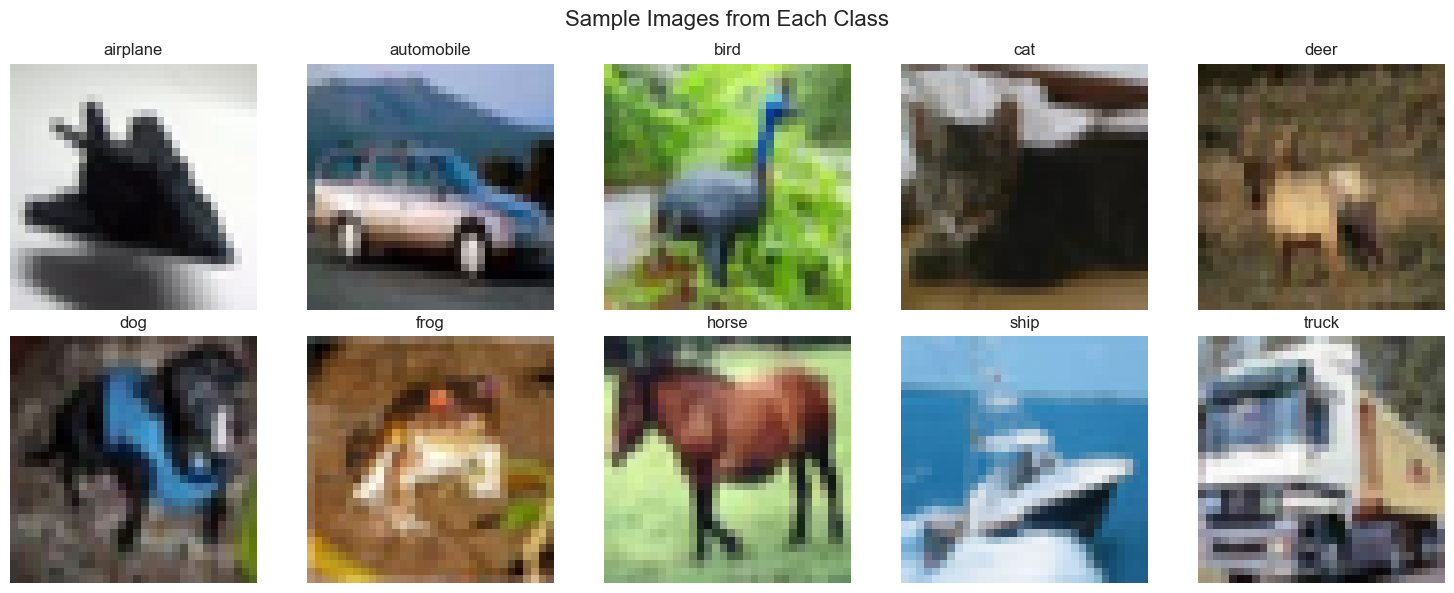

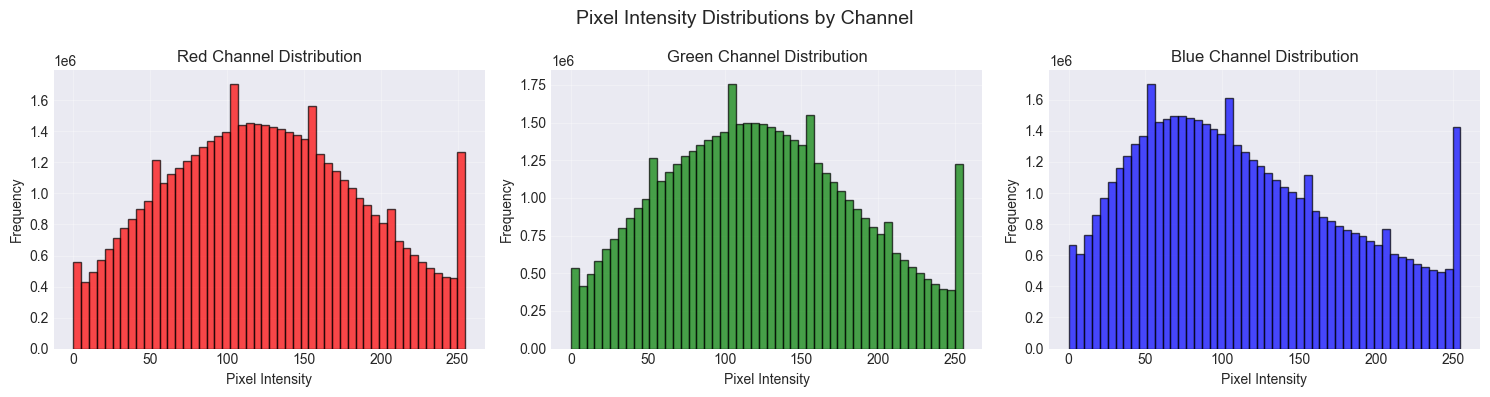

In [5]:
# Display sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    # Find first image of each class
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(x_train[idx])
    axes[i].set_title(f"{class_names[i]}")
    axes[i].axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

# Show pixel value distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['red', 'green', 'blue']
channels = ['Red', 'Green', 'Blue']

for i, (ax, color, channel) in enumerate(zip(axes, colors, channels)):
    pixel_values = x_train[..., i].flatten()
    ax.hist(pixel_values, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_title(f'{channel} Channel Distribution')
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.suptitle("Pixel Intensity Distributions by Channel", fontsize=14)
plt.tight_layout()
plt.show()

## Preprocessing

In [7]:
# Normalize pixel values to [0, 1] and convert to float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert to PyTorch tensors (changing from HWC to CHW format)
x_train_tensor = torch.from_numpy(x_train.transpose(0, 3, 1, 2))  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.from_numpy(y_train).long()
x_test_tensor = torch.from_numpy(x_test.transpose(0, 3, 1, 2))
y_test_tensor = torch.from_numpy(y_test).long()

# Move to device
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print("Data preprocessed and converted to tensors")
print(f"Training tensor shape: {x_train_tensor.shape}")  # Should be (50000, 3, 32, 32)
print(f"Test tensor shape: {x_test_tensor.shape}")

# Create datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Split training into train/val (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"\nDataset splits:")
print(f"Training: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nData loaders created (batch size = {batch_size})")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Data preprocessed and converted to tensors
Training tensor shape: torch.Size([50000, 3, 32, 32])
Test tensor shape: torch.Size([10000, 3, 32, 32])

Dataset splits:
Training: 40000 samples
Validation: 10000 samples
Test: 10000 samples

Data loaders created (batch size = 64)
Training batches: 625
Validation batches: 157
Test batches: 157


In [9]:
# Save the data loaders and metadata
processed_data = {
    'train_loader': train_loader,
    'val_loader': val_loader,
    'test_loader': test_loader,
    'batch_size': batch_size,
    'class_names': class_names,
    'device': device
}

with open('cifar10_loaders.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("DataLoaders saved to cifar10_loaders.pkl")

DataLoaders saved to cifar10_loaders.pkl
